# Deep RL Algos

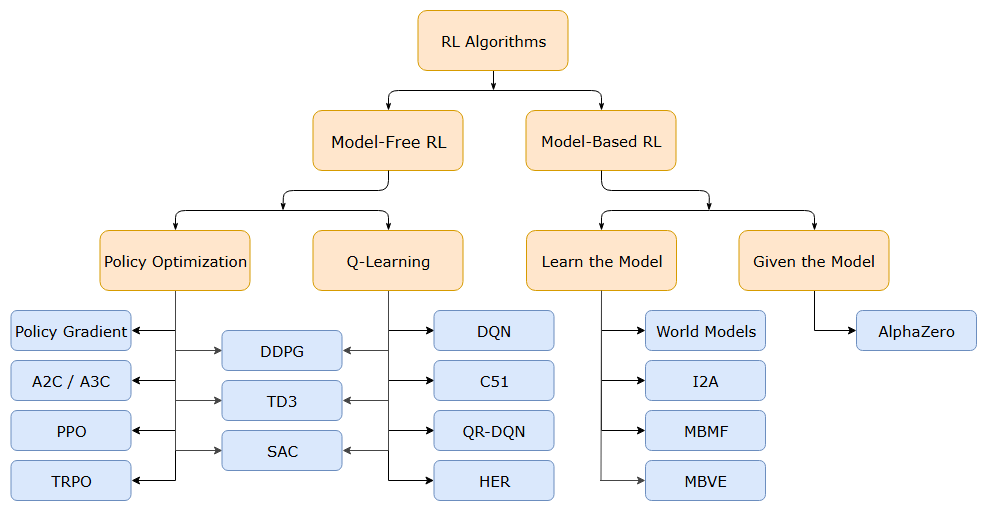

A very broad (but slightly outdated) overview of different popular RL algorithms

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import namedtuple, deque

In [ ]:
from IPython.display import display, clear_output, HTML
import imageio
import base64
import matplotlib.pyplot as plt
import time

def live_plot(fig, ax, line, x, y, x_name='x', y_name='y', title_name='Data'):
    line.set_data(x, y)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(f'{x_name} vs {y_name} for {title_name}')

    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True) # Clear output before displaying the updated plot
    display(fig)            # Display the updated plot

def display_frames_as_gif(frames):
    """Displays a list of frames as a gif"""

    # Encode frames to video
    with imageio.get_writer('animation.mp4', mode='I', fps=60) as writer:
        for frame in frames:
            writer.append_data(frame)

    # Read video and encode to base64
    with open('animation.mp4', 'rb') as f:
        video_data = f.read()
    video_data_base64 = base64.b64encode(video_data).decode('utf-8')

    # Create HTML video element
    html = f"""
    <video width="400" height="300" controls>
        <source src="data:video/mp4;base64,{video_data_base64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display the video in the notebook
    display(HTML(html))

def play_agent(env_name, agent):
    env = gym.make(env_name)
    state = env.reset()

    frames = []
    tot_rewards = 0.
    episode_len = 0
    avg_rewards = []
    avg_eps_len = []

    for _ in range(1000):
        action = agent.select_action(state)

        next_state, reward, done, _ = env.step(action)

        state = next_state

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        tot_rewards += reward
        episode_len += 1
        if done:
            env.reset()
            avg_rewards.append(tot_rewards)
            avg_eps_len.append(episode_len)
            tot_rewards = 0.
            episode_len = 0

    env.close()
    display_frames_as_gif(frames)

    print('Average Reward: ', np.mean(avg_rewards))
    print('Average Episode Length: ', np.mean(avg_eps_len))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Deep Q-Learning Networks (DQN)

A foundational algorithm combining Q-learning with deep neural networks. For the main paper, please refer to [Mnih et al., 2013](https://arxiv.org/abs/1312.5602).


### Some Highlights on why DQN?

1. For continuous state spaces, it is infeasible to represent all possible states explicitly in a Q-table.
    - Even discretizing the state space can lead to exponential growth in memory requirements and inefficiency in learning due to sparse coverage. Hence use function approximators to tackle this.
2. It is found that training on consecutive data caused instability because the samples were not independent.
    - The replay buffer was introduced to break these correlations by randomizing the order of training data.
3. Instability arises when the Q-network tries to bootstrap its own estimates, especially as the network is updated frequently.
    - Introduces a second network (target network) to compute the Bellman backup. The target network is updated less frequently, decoupling the learning target from the rapidly changing Q-network.


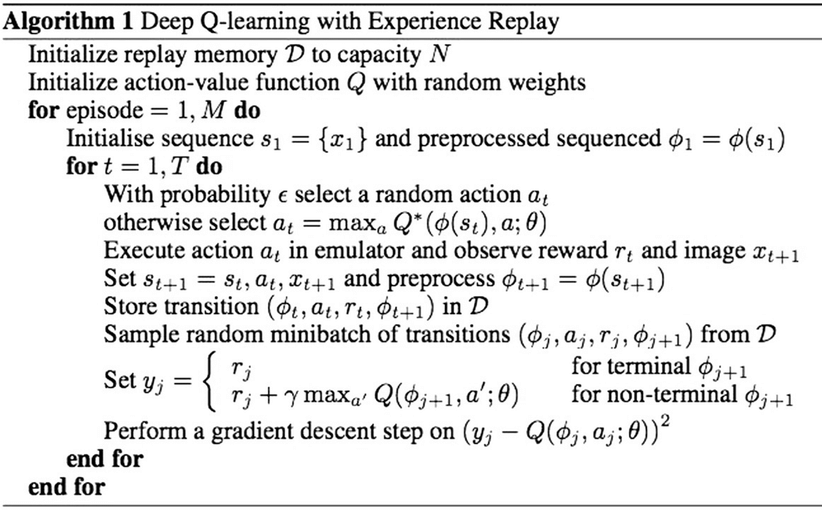


In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add_experience(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=0.001, tau=1e-3, update_freq=2, update_freq_q=2):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.update_every = update_freq
        self.update_every_q = update_freq_q

        self.q_network = QNetwork(state_size, action_size)
        self.target_q_network = QNetwork(state_size, action_size)
        self.target_q_network.load_state_dict(self.q_network.state_dict())
        self.target_q_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        self.memory = ReplayBuffer(capacity=10000)

        self.t_step = 0
        self.q_update_t = 0

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()

    def train(self, batch_size):
        # Learn every update_every time steps.

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory.buffer) < batch_size:
                return

            experiences = self.memory.sample(batch_size)
            batch = self.experience_to_batch(experiences)
            states, actions, rewards, next_states, dones = batch

            current_q_values = self.q_network(states).gather(1, actions)
            target_q_values = rewards + (self.gamma * torch.max(self.target_q_network(next_states), dim=1, keepdim=True)[0]) * (1 - dones)

            loss = nn.functional.mse_loss(current_q_values, target_q_values)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.q_update_t = (self.q_update_t + 1) % self.update_every_q
            if self.q_update_t == 0:
                self.update_target_q_network()

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def update_target_q_network(self):
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # EMA
        # for target_param, local_param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
        #     target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def experience_to_batch(self, experiences):
        batch = self.memory.experience(*zip(*experiences))
        states = torch.FloatTensor(np.vstack(batch.state))
        actions = torch.LongTensor(np.vstack(batch.action))
        rewards = torch.FloatTensor(np.vstack(batch.reward))
        next_states = torch.FloatTensor(np.vstack(batch.next_state))
        dones = torch.FloatTensor(np.vstack(batch.done))
        return states, actions, rewards, next_states, dones

In [ ]:
def learn_dqn(env_name='CartPole-v1',
              episodes=500, batch_size=32,
              gamma=0.995, update_freq=2, tau=1e-3):
    start_time = time.time()

    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size, gamma=0.995, update_freq=2, tau=1e-3)

    episode_lists = [0.,]
    reward_lists = [0.,]
    fig, ax = plt.subplots()
    line, = ax.plot(episode_lists, reward_lists)

    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        episode_reward = 0.

        while True:
            with torch.inference_mode():
                action = agent.select_action(state)

                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, state_size])

                agent.memory.add_experience(state, action, reward, next_state, done)

            agent.train(batch_size)

            episode_reward += reward
            state = next_state

            if done:
                break

        episode_lists.append(episode)
        reward_lists.append(episode_reward)

        if episode % 50 == 0:
            live_plot(fig, ax, line, episode_lists, reward_lists, 'Episode', 'Episode Reward', f'DQN in {env_name}')

    end_time = time.time()
    plt.close()
    print('Time Taken (min): ', (end_time - start_time)/60)

    return agent

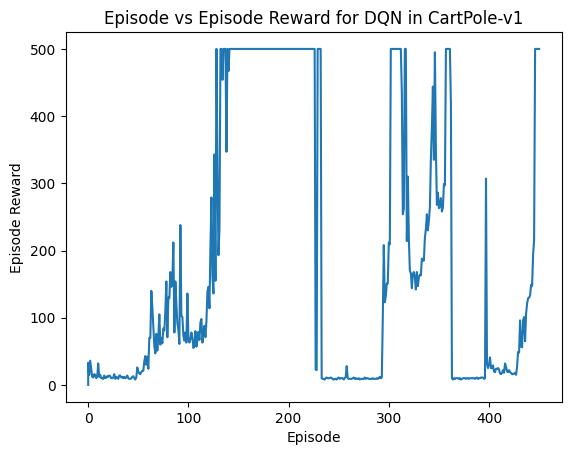

Time Taken (min):  2.817726218700409


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. S

In [ ]:
%matplotlib inline

env_name = 'CartPole-v1'
learned_agent_dqn = learn_dqn(env_name)
play_agent(env_name, learned_agent_dqn)

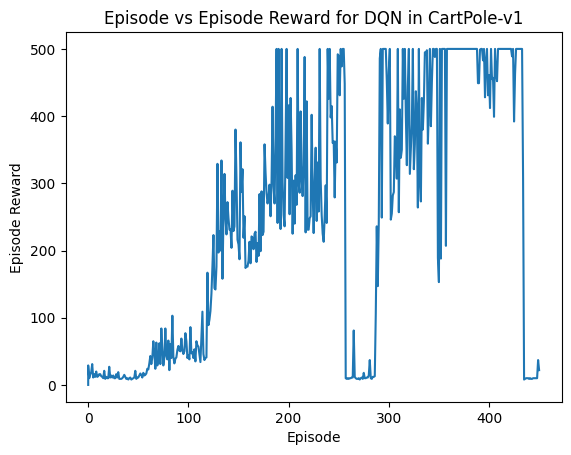

Time Taken (min):  3.1716447909673056


Average Reward:  500.0
Average Episode Length:  500.0


In [ ]:
%matplotlib inline

env_name = 'CartPole-v1'
learned_agent_dqn = learn_dqn(env_name, update_freq=6)
play_agent(env_name, learned_agent_dqn)

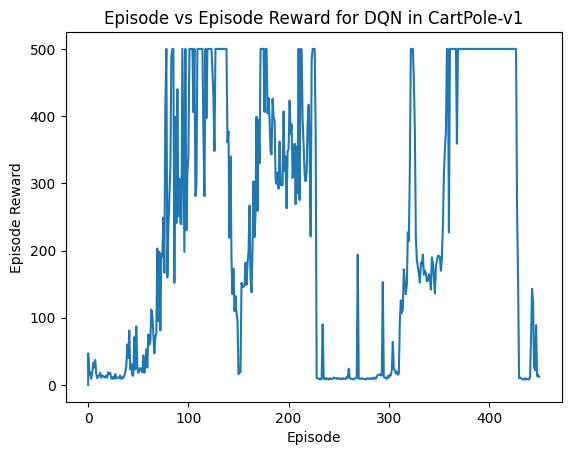

Time Taken (min):  2.734176341692607


Average Reward:  110.33333333333333
Average Episode Length:  110.33333333333333


In [ ]:
%matplotlib inline

env_name = 'CartPole-v1'
learned_agent_dqn = learn_dqn(env_name, update_freq=1)
play_agent(env_name, learned_agent_dqn)

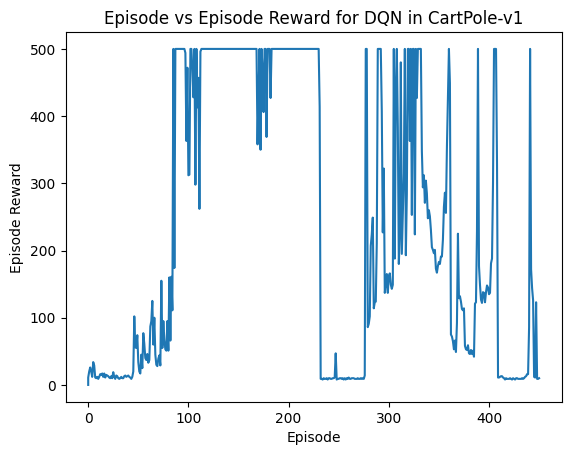

Time Taken (min):  3.0593862692515055


Average Reward:  500.0
Average Episode Length:  500.0


In [ ]:
%matplotlib inline

env_name = 'CartPole-v1'
learned_agent_dqn = learn_dqn(env_name, gamma=0.75)
play_agent(env_name, learned_agent_dqn)